2D Example demonstrating a spill and well separated by a stream.

In [1]:
import sys
import math
from io import StringIO
import os
import shutil
import platform
import numpy as np
from subprocess import check_output
import flopy
import pandas as pd
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

import config

print(np.__version__)

modelpth = os.path.join('Cara_model')
modelname = 'Spill'
mfexe = 'mfnwt'
mtexe = 'mt3dusgs'
if platform.system() == 'Windows':
    mfexe += '.exe'
    mtexe += '.exe'

# Instantiate MODFLOW model
mf = flopy.modflow.Modflow(modelname, version='mfnwt', exe_name=mfexe, 
                           model_ws=modelpth)

# Output Control: Create a flopy output control object
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0,0):['save head','save budget']})

# Newton-Rhapson Solver: Create a flopy nwt package object
headtol = 0.0001
fluxtol = 0.06
maxiterout = 200
thickfact = 1E-005
linmeth = 2
iprnwt = 1
ibotav = 0
nwt = flopy.modflow.ModflowNwt(mf, headtol=headtol, fluxtol=fluxtol, maxiterout=maxiterout,
                               thickfact=thickfact, linmeth=linmeth, iprnwt=iprnwt, ibotav=ibotav,
                               options='MODERATE')



Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mf2005.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mfnwt.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mp7.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mt3dms.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mt3dusgs.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\mf6.exe
Executable file found: D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\bin\win64\gridgen.exe
1.14.1


Since this is a hyporthetical model, we will generate ground surface from some some equations

In [2]:
# Note that defining the ground surface this way allows to rediscretize on the fly if needed.
def topElev_Center(x,y):
    return ((-0.003 * x) + 260.) + (((-2E-9 * (x - 5000.)) + 1E-5) * (y + 1500.)**2)

# Model domain and grid definition
Lx = 10000.
Ly = 3000.
nlay = 1
nrow = 30
ncol = 100

delr = Lx / ncol
delc = Ly / nrow

xmax = ncol * delr
ymax = nrow * delc

X, Y = np.meshgrid(np.linspace(delr / 2, xmax - delr / 2, ncol),
                   np.linspace(ymax - delc / 2, 0 + delc / 2, nrow))

ibound = np.ones((nlay, nrow, ncol))

# modify the y values a bit
Y_mm = -1* np.flipud(Y)
topElev = topElev_Center(X, Y_mm)
botElev = np.zeros(topElev.shape)
strtElev= topElev - 1.

Steady = [True,False,False]
nstp = [1, 100, 200]
tsmult = [1, 1, 1]
perlen = [1, 36525, 73050]
    
# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, nper=3, delr=delr, delc=delc,
                               top=topElev, botm=botElev, laycbd=0, itmuni=4, lenuni=1,
                               steady=Steady, nstp=nstp, tsmult=tsmult, perlen=perlen)

Now instatiate the UPW package

In [3]:
laytyp = 1
layavg = 0
chani = 1.0
layvka = 0
hdry = -2e+20
iphdry = 1
hk = 10.
hani = 1
vka = 0.01
ss = 0.00001
sy = 0.20

upw = flopy.modflow.ModflowUpw(mf, laytyp=laytyp, layavg=layavg, chani=chani, layvka=layvka,
                               ipakcb=53, hdry=hdry, iphdry=iphdry, hk=hk, hani=hani,
                               vka=vka, ss=ss, sy=sy)

# Instantiate BAS
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, hnoflo=hdry, strt=strtElev)

Now work on instantiating the boundary conditions

In [4]:
# Recharge Package: The total volume coming in from the upper and lower rows should 
# total 2000.0 on each side (4,000 total)
rech = np.zeros_like(topElev)
individual_cell_rate = 2000. / ncol / (delr*delc)
rech[0,:] = rech[-1,:] = individual_cell_rate
irch = np.zeros_like(rech)  # Remember, 0-based silliness in use
   
rch = flopy.modflow.ModflowRch(mf, nrchop=1, ipakcb=53, rech=rech, irch=irch)

In [5]:
# Evapotranspiration Package: The ET rate is 0.003 everywhere in the model, so rediscretization
# doesn't matter, can keep a constant rate.
nevtop = 1
evtr = 0.003
surf = topElev
exdp = 15
evt = flopy.modflow.ModflowEvt(mf, nevtop=nevtop, ipakcb=53, surf=surf, evtr=evtr, exdp=exdp)

In [6]:
# Streamflow Routing Package: Try and set up with minimal options in use
# 9 11 IFACE # Data Set 1: ISTCB1  ISTCB2
nstrm = 100
nss = 1
const = 1.283833650957E+005
dleak = 0.0001
istcb1 = 53
istcb2 = 0
isfropt = 0
nstrail = 10
isuzn = 1
nsfrsets = 30
irtflg = 1
numtim = 2
weight = 0.75
flwtol = 0.0001
segment_data = None
channel_geometry_data = None
channel_flow_data = None
dataset_5 = None
reachinput = False

# The next couple of lines set up the reach_data for the 30x100 hypothetical model.
# Will need to adjust the row based on which grid discretization we're doing.
# Ensure that the stream goes down one of the middle rows of the model.

# Determine the middle row and store in rMid (account for 0-base)
rMid = nrow//2 - 1

s1 = "k,i,j,iseg,ireach,rchlen,iface\n"
for y in range(ncol):
    #    layer +    row    +        col   +  iseg +   irch      +     rchlen     +    iface
    s1 += '0,' + str(rMid) + ',' + str(y) + ',1,' + str(y+1) + ',' + str(delr) + ',' + '0\n'

s1 = StringIO(s1)
reach_data = np.genfromtxt(s1, delimiter=',',names=True, dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8')])

# Will need to adjust the elevations of the upper and lower ends of the segment based on topElev array
# 5 m below ground surface (5 m of stream incision)
s2 = StringIO(u"nseg,icalc,outseg,iupseg,nstrpts,flow,runoff,etsw,pptsw,roughch,roughbk,cdpth,fdpth,awdth,bwdth,hcond1,thickm1,elevup,width1,depth1,hcond2,thickm2,elevdn,width2,depth2\n1,1,0,0,0,40000.0,0.0,0.0,0.0,0.028,0.0,0.0,0.0,0.0,0.0,1.0,1.0,254.899750,20.0,0.0,1.0,1.0,225.150250,20.0,0.0")
segment_data = np.genfromtxt(s2, delimiter=',',names=True)

# Adjust the elevations of the upstream and downstream ends of the segment
segment_data['elevup'] = topElev[rMid,0] - 5.
segment_data['elevdn'] = topElev[rMid,ncol-1] - 5.

# Be sure to convert segment_data to a dictionary keyed on stress period.
segment_data = np.atleast_1d(segment_data)
segment_data = {0: segment_data,
                1: segment_data,
                2: segment_data}

# There are 2 stress periods
dataset_5 = {0: [nss, 0, 0],
             1: [nss, 0, 0],
             2: [nss, 0, 0]}

channel_flow_data = {0: {1:[[ 1.0E+00, 1.0E+00, 2.5489975E+02, 2.0E+01],    #Data set 6b: HCOND1 THICKM1 ELEVUP WIDTH1
                            [ 1.0E+00, 1.0E+00, 2.2515025E+02, 2.0E+01]]},  #Data set 6c: HCOND2 THICKM2 ELEVDN WIDTH2
                     1: {2:[[ 1.0E+00, 1.0E+00, 2.5489975E+02, 2.0E+01],    #Data set 6b: HCOND1 THICKM1 ELEVUP WIDTH1
                            [ 1.0E+00, 1.0E+00, 2.2515025E+02, 2.0E+01]]},} #Data set 6c: HCOND2 THICKM2 ELEVDN WIDTH2

sfr = flopy.modflow.ModflowSfr2(mf, nstrm=nstrm, nss=nss, const=const, dleak=dleak,
                                ipakcb=53, istcb2=0, reach_data=reach_data, dataset_5=dataset_5,
                                segment_data=segment_data, channel_flow_data=channel_flow_data)

In [7]:
gages = [[1,int(ncol/4),61,1],[1,int(ncol/2),62,1], [1,int(ncol*3/4),63,1], [1,ncol,64,1]]
files = ['CrnkNic.gage','CrnkNic.gag1','CrnkNic.gag2','CrnkNic.gag3','CrnkNic.gag4']
gage = flopy.modflow.ModflowGage(mf, numgage=len(gages), gage_data=gages, filenames = files)

In [8]:
# Add a municipal pumping supply well
wel = flopy.modflow.ModflowWel(mf, ipakcb=53, stress_period_data = {1:[[0, 11, 74, -1.5e5],
                                                                       [0, 17, 25, 1.5e-5]]})

In [9]:
# Add the Link MT3D package for generating the linker file
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='Spill.ftl', output_file_header='extended',
                               output_file_format='formatted', package_flows = ['sfr'])

In [10]:
# Investigate the effects of hfb
mxfb = nrow
nhfbnp = nrow
hfb_data = [[0, i, 34, i, 35, 0.0001] for i in range(nrow)]   # Layer IROW1 ICOL1 IROW2  ICOL2 Hydchr 

hfb = flopy.modflow.ModflowHfb(mf, nhfbnp = nhfbnp, hfb_data = hfb_data)

In [11]:
mf.write_input()
mf.run_model()

FloPy is using the following  executable to run the model: c:\bin\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: Spill.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/24 14:21:52

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Str

 Solving:  Stress period:     2    Time step:    99    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:   100    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     5    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     6    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     7    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Groundwater-Flow Eqn.

 Solving:  Stress period:     3    Time step:   108    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   109    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   110    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   111    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   112    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   113    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   114    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   115    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   116    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   117    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   118    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   119    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:   120    Groundwater-Flow Eqn.

(True, [])

In [12]:
hdsobj = bf.HeadFile(os.path.join(modelpth,'{0}.hds'.format('Spill')))
totim = hdsobj.get_times()
totim
hds = hdsobj.get_data(totim=totim[0])
#hds = []
#for tm in totim:
#    hds.append(hdsobj.get_data(totim=tm))

print(hds.shape)

depth = topElev - hds[0,:,:]
print(depth.shape)
print(depth.max())
print(depth.min())


(1, 30, 100)
(30, 100)
50.367667480468754
2.364629150390641


In [13]:
hdr = ['Time', 'Stage', 'Flow', 'Depth', 'Width', 'Midpt_Flow', 'Precip', 'ET', 'Runoff']
for j in range(4):
    fname = os.path.join(modelpth, 'CrnkNic.gag' + str(j + 1))
    wha = pd.read_table(fname, header=None, skiprows=2, names=hdr, delim_whitespace=True)

    if j == 0:
        wha.drop(wha.columns.difference(['Time', 'Flow']), 1, inplace=True)
        df = wha.copy()
        df.rename(columns={'Flow': 'Flow' + str(j + 1)}, inplace=True)

    if j != 0:
        df = pd.merge(df, wha[['Time', 'Flow']], on='Time', how='left')
        df.rename(columns={'Flow': 'Flow' + str(j + 1)}, inplace=True)


df = df[['Time','Flow1','Flow2','Flow3','Flow4']]


#try:
#    plt.close('all')
#except:
#    pass

#fig = plt.figure(figsize=(15, 5), facecolor='w')
#ax = fig.add_subplot(1, 1, 1)

#lns1 = ax.plot(df['Time'], df['Flow1']*35.315/86400, 'b-', linewidth=1.0, label='1/4')
#lns2 = ax.plot(df['Time'], df['Flow2']*35.315/86400, 'k-', linewidth=1.0, label='1/2')
#lns3 = ax.plot(df['Time'], df['Flow2']*35.315/86400, 'r-', linewidth=1.0, label='3/4')
#lns4 = ax.plot(df['Time'], df['Flow2']*35.315/86400, 'g-', linewidth=1.0, label='end')

#customize plot
#ax.set_xlabel('Time, days')
#ax.set_ylabel('Flow, cfs')
#ax.set_ylim([0,20])
#ticksize = 10

# add 4 items to legend
#lns = lns1+lns2+lns3+lns4
#labs = [l.get_label() for l in lns]

#legend
#leg = ax.legend(lns,labs,
#                loc='upper left', labelspacing=0.25, columnspacing=1,
#                handletextpad=0.5, handlelength=2.0, numpoints=1)
#leg._drawFrame = False 

#plt.show()




## Setup Transport Model

In [14]:
mt = flopy.mt3d.Mt3dms(modflowmodel=mf, modelname=modelname, model_ws=modelpth,
                       version='mt3d-usgs', namefile_ext='mtnam', exe_name=mtexe,
                       ftlfilename='Spill.ftl', ftlfree=True)

# BTN package
ncomp   =    1
lunit   =    'm'
sconc   =    0.0
prsity  =    sy
cinact  =   -1.0
thkmin  =    0.000001
nprs    =   -1
nprobs  =   10
nprmas  =   10
dt0     =  100.0
nstp    = nstp    # From DIS setup
mxstrn  = 5000
ttsmult =    1.0
ttsmax  =    0

#obs = [[0, 10, 15]]

btn = flopy.mt3d.Mt3dBtn(mt, MFStyleArr=True, DRYCell=True, lunit=lunit,
                         sconc=sconc, ncomp=ncomp, prsity=prsity, cinact=cinact,
                         thkmin=thkmin, nprs=nprs, nprobs=nprobs, 
                         chkmas=True,nprmas=nprmas, dt0=dt0,  
                         mxstrn=mxstrn, ttsmult=ttsmult, ttsmax=ttsmax)
# ADV package
mixelm =    0
percel =    1.0000
mxpart = 5000
nadvfd =    1      # (1 = Upstream weighting)

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=percel, mxpart=mxpart, 
                         nadvfd=nadvfd)

#GCG solver package
mxiter =   1
iter1  = 200
isolve =   3
ncrs   =   0
accl   =   1.000000
cclose =   1.00e-06
iprgcg =   5

gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=mxiter, iter1=iter1, 
                         isolve=isolve, ncrs=ncrs, accl=accl, 
                         cclose=cclose, iprgcg=iprgcg)

# SSM
# ---

# First, get a dictionary that has the SSM itype for each of the boundary types.
itype = flopy.mt3d.Mt3dSsm.itype_dict()


mxss = 3002          # maximum number of boundary conditions
ssm_data = {}
#             kss,iss,jss,css,        ITYPE
ssm_data[0] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25,   0., itype['CC'])]          #Concstant Concentration
ssm_data[1] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25, 100., itype['CC'])]
ssm_data[2] = [(0, 11, 74,   0., itype['WEL']),
               (0, 17, 25,   0., itype['CC'])]

ssm = flopy.mt3d.Mt3dSsm(mt, mxss=mxss, stress_period_data=ssm_data)

# SFT
# ---
dispsf = 1
coldsf = 0
seg_len = np.unique(reach_data['iseg'], return_counts=True)
obs_sf = np.cumsum(seg_len[1])
obs_sf = obs_sf.tolist()

print(seg_len)
print('value: ' + str(obs_sf))

# In the first and last stress periods, concentration at the headwater is 0.0
sf_stress_period_data = {0: [0, 0, 0.0],
                         1: [0, 0, 0.0],
                         2: [0, 0, 0.0]}

gage_output = [None, None, 'CrnkNic.sftobs']

sft = flopy.mt3d.Mt3dSft(mt, nsfinit=100, mxsfbc=100, icbcsf=81, ioutobs=82,
                         isfsolv=1, cclosesf=1.0E-5, mxitersf=100, crntsf=1.0, iprtxmd=0,
                         coldsf=coldsf, dispsf=dispsf, nobssf=1, obs_sf=obs_sf,
                         sf_stress_period_data = sf_stress_period_data,
                         filenames=gage_output)



found 'rch' in modflow model, resetting crch to 0.0
found 'ets'/'evt' in modflow model, resetting cevt to 0.0
(array([1.]), array([100], dtype=int64))
value: [100]


### Run MT3D-USGS

In [15]:
mt.write_input()
mt.run_model()

FloPy is using the following  executable to run the model: c:\bin\mt3dusgs.exe

 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.00.00] 
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: Spill.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    1.0000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   1.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.    2

 TIME STEP NO.    1
 FROM TIME =   1.0000     TO    366.25    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   101.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8797E-01  [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3318E-03  [K,I,J]    1   17   28
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1452E-05  [K,I,J]    1   16   29
 Outer Iter.  1  Inner Iter.  4:  Max


 TIME STEP NO.    7
 FROM TIME =   2192.5     TO    2557.8    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   2292.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1344E-01  [K,I,J]    1   18   28
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3443E-04  [K,I,J]    1   16   30
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2215E-06  [K,I,J]    1   14   50
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   2392.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1262E-01  [K,I,J]    1   17   29
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3220E-04  [K,I,J]    1   18   29
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1658E-06  [K,I,J]    1   15   31
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   2492.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1237E-01  [K,I,J]    1   17   29
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3085E-04  [K,I,J]    1   18   29
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1653E-06


 TIME STEP NO.   14
 FROM TIME =   4749.2     TO    5114.5    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   4849.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7607E-02  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2111E-04  [K,I,J]    1   15   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8056E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   4949.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7403E-02  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2073E-04  [K,I,J]    1   15   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8620E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   5049.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7191E-02  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2016E-04  [K,I,J]    1   15   33
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9110E-06

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1423E-05  [K,I,J]    1   15   35
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5774E-07  [K,I,J]    1   14   37
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   7140.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4773E-02  [K,I,J]    1   16   33
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1362E-04  [K,I,J]    1   15   35
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1587E-05  [K,I,J]    1   15   35
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5309E-07  [K,I,J]    1   14   48
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   7240.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4711E-02  [K,I,J]    1   16   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1359E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1602E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5681E-07  [K,I,J]    1   14   37
 Transport Step:    4   Step Size:   65.

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   9232.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3469E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1501E-04  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1706E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8941E-07  [K,I,J]    1   15   36
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   9332.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3409E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1681E-04  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1611E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8568E-07  [K,I,J]    1   15   36
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   9432.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3347E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   11524.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2123E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1180E-04  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6724E-06  [K,I,J]    1   15   36
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   11624.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2059E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1182E-04  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6594E-06  [K,I,J]    1   15   36
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   11689.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1316E-02  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5679E-05  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2231E-06  [K,I,J]    1   13   75

 TIME STEP NO.   33
 FROM TIME =   1168

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   13980.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1003E-02  [K,I,J]    1   17   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9791E-06  [K,I,J]    1   12   76
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   14080.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9718E-03  [K,I,J]    1   17   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2810E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1869E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3725E-07  [K,I,J]    1   13   74
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   14180.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9409E-03  [K,I,J]    1   17   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1424E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2503E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   16007.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5564E-03  [K,I,J]    1   17   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1373E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1927E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8009E-07  [K,I,J]    1   13   74
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   16072.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3546E-03  [K,I,J]    1   17   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8045E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3893E-06  [K,I,J]    1   12   76

 TIME STEP NO.   45
 FROM TIME =   16072.     TO    16437.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   16172.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5347E-03  [K,I,J]    1   17   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1460E-04


 TIME STEP NO.   50
 FROM TIME =   17898.     TO    18264.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   17998.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3489E-03  [K,I,J]    1   23   72
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1772E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8880E-06  [K,I,J]    1   12   76
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   18098.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3430E-03  [K,I,J]    1   23   72
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1764E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8522E-06  [K,I,J]    1   12   76
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   18198.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3377E-03  [K,I,J]    1   22   74
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1761E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8340E-06

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   20290.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2600E-03  [K,I,J]    1   16   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1663E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1304E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4061E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   20390.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2553E-03  [K,I,J]    1   16   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1644E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1328E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4340E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   20455.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1647E-03  [K,I,J]    1   16   78
 Outer Iter.  1  Inner Iter.  2:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1183E-03  [K,I,J]    1   16   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6927E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4023E-06  [K,I,J]    1   12   75

 TIME STEP NO.   62
 FROM TIME =   22281.     TO    22646.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   22381.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1783E-03  [K,I,J]    1   16   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1306E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4172E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   22481.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1744E-03  [K,I,J]    1   16   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1282E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4508E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total El

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   25203.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6387E-04  [K,I,J]    1   15   80
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4061E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2310E-06  [K,I,J]    1   12   75

 TIME STEP NO.   70
 FROM TIME =   25203.     TO    25568.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   25303.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9587E-04  [K,I,J]    1   15   80
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7687E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4098E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   25403.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9361E-04  [K,I,J]    1   15   80
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7507E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4023E-06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   28225.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5262E-04  [K,I,J]    1   14   82
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3953E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2142E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   28325.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5165E-04  [K,I,J]    1   14   82
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3848E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2086E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   28425.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5069E-04  [K,I,J]    1   14   82
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3750E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2049E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   30617.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3406E-04  [K,I,J]    1   14   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2134E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1136E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   30682.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2202E-04  [K,I,J]    1   14   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1071E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5774E-07  [K,I,J]    1   12   75

 TIME STEP NO.   85
 FROM TIME =   30682.     TO    31047.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   30782.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3320E-04  [K,I,J]    1   14   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2047E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1080E-06

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2353E-04  [K,I,J]    1   13   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1095E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5588E-07  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   33074.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2319E-04  [K,I,J]    1   13   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1062E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5402E-07  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   33174.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2285E-04  [K,I,J]    1   13   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1029E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5215E-07  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   33239.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   36461.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1449E-04  [K,I,J]    1   13   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4456E-06  [K,I,J]    1   11   77
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   36526.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9909E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1807E-06  [K,I,J]    1   14   37

 STRESS PERIOD NO.    3

 TIME STEP NO.    1
 FROM TIME =   36526.     TO    36891.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   36626.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1167      [K,I,J]    1   18   27
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1577E-03  [K,I,J]    1   17   28
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2012E-06  [K,I,J]    1   16   29
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   36726.    
 Outer Iter.  1  Inner Iter.  

 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   39083.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3056E-01  [K,I,J]    1   18   29
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2337E-04  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1304E-06  [K,I,J]    1   14   47

 TIME STEP NO.    8
 FROM TIME =   39083.     TO    39448.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   39183.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4487E-01  [K,I,J]    1   18   29
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7480E-04  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4917E-06  [K,I,J]    1   14   48
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   39283.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4308E-01  [K,I,J]    1   18   29
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7099E-04  [K,I,J]    1   17   31
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3129E-06

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2029E-01  [K,I,J]    1   17   32
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2155E-04  [K,I,J]    1   15   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6594E-06  [K,I,J]    1   14   48

 TIME STEP NO.   15
 FROM TIME =   41640.     TO    42005.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   41740.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3082E-01  [K,I,J]    1   17   32
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7111E-04  [K,I,J]    1   15   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1632E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1043E-06  [K,I,J]    1   14   37
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   41840.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3056E-01  [K,I,J]    1   17   32
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7212E-04  [K,I,J]    1   15   34
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1062E-05

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   43766.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3145E-01  [K,I,J]    1   16   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1180E-03  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6258E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4917E-06  [K,I,J]    1   14   37
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   43831.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2091E-01  [K,I,J]    1   16   34
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4107E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2511E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8196E-07  [K,I,J]    1   14   37

 TIME STEP NO.   21
 FROM TIME =   43831.     TO    44196.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   43931.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3213E-01

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   45757.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4289E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1546E-03  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5682E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2887E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1341E-06  [K,I,J]    1   15   36
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   45857.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4353E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1515E-03  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3356E-04  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5826E-05  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1118E-06  [K,I,J]    1   15   36
 Transport Step:    3   Step Size:   100

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1663E-04  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1937E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5960E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   47684.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4520E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3444E-03  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1746E-04  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1699E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3576E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   47784.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4363E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3393E-03  [K,I,J]    1   13   75
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1716E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1944E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5364E-06  [K,I,J]    1   12   76

 TIME STEP NO.   36
 FROM TIME =   49310.     TO    49675.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   49410.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2308E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6042E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1672E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1550E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2086E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   49510.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2213E-01  [K,I,J]    1   16   35
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6822E-03

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3874E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   51336.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2402E-01  [K,I,J]    1   24   68
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7860E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1165E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4321E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3874E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   51436.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2409E-01  [K,I,J]    1   24   68
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8174E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1112E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4500E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   53162.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2549E-01  [K,I,J]    1   21   75
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1351E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6354E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1101E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5662E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   53262.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2560E-01  [K,I,J]    1   21   75
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1381E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6300E-04  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1188E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5811E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1786E-02  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1690E-02  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4768E-06  [K,I,J]    1   12   76
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   54988.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2891E-01  [K,I,J]    1   16   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1837E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1151E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2135E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.6258E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   55088.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2910E-01  [K,I,J]    1   16   78
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1862E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2926E-01  [K,I,J]    1   16   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2068E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1184E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5841E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1043E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.5960E-07  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   56815.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2921E-01  [K,I,J]    1   16   79
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2075E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1198E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6050E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1103E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.4470E-07  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   58376.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2728E-01  [K,I,J]    1   15   80
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2009E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1224E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4321E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.9537E-06  [K,I,J]    1   12   76
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   58441.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1789E-01  [K,I,J]    1   15   80
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1045E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6089E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2369E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4172E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3055E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   60202.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2401E-01  [K,I,J]    1   15   82
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1683E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1014E-03  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4143E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2980E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   60267.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1574E-01  [K,I,J]    1   15   82
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8606E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4870E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   61928.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2147E-01  [K,I,J]    1   15   83
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1283E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7417E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3159E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2012E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   62028.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2130E-01  [K,I,J]    1   15   83
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1260E-02  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7261E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3129E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2012E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   63854.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1879E-01  [K,I,J]    1   14   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8607E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4701E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2310E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.7823E-07  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   63920.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1229E-01  [K,I,J]    1   14   84
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4269E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2190E-04  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8196E-06  [K,I,J]    1   12   76

 TIME STEP NO.   76
 FROM TIME =   63920.     TO    64285.    

 Transport Step:    1   Step Size:   100.0     Total El

 TIME STEP NO.   81
 FROM TIME =   65746.     TO    66111.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   65846.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1698E-01  [K,I,J]    1   14   85
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5210E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3677E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3278E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2012E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   65946.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1690E-01  [K,I,J]    1   14   85
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5067E-03  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3767E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3219E-05  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2123E-06 

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   67672.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1523E-01  [K,I,J]    1   14   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3893E-03  [K,I,J]    1   11   78
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5058E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3148E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3204E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   67772.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1513E-01  [K,I,J]    1   14   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3910E-03  [K,I,J]    1   11   78
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5117E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3185E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3241E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1388E-01  [K,I,J]    1   13   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4137E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5680E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3729E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3912E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   69764.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9069E-02  [K,I,J]    1   13   86
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1668E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2298E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9947E-06  [K,I,J]    1   12   75

 TIME STEP NO.   92
 FROM TIME =   69764.     TO    70129.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   69864.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1379E-01

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   71690.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1298E-01  [K,I,J]    1   13   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4095E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5124E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3906E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4321E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   71790.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1293E-01  [K,I,J]    1   13   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4089E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5083E-04  [K,I,J]    1   11   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3904E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4340E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   73351.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1210E-01  [K,I,J]    1   13   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3852E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5454E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3602E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4396E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   73416.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7891E-02  [K,I,J]    1   13   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1649E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2597E-04  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1127E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2980E-06  [K,I,J]    1   12   75

 TIME STEP NO.  102
 FROM TIME =   7341

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1115E-01  [K,I,J]    1   12   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3486E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5439E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2820E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4284E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   75177.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1110E-01  [K,I,J]    1   12   87
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3466E-03  [K,I,J]    1   11   77
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5432E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2777E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4265E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   75242.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


 TIME STEP NO.  112
 FROM TIME =   77069.     TO    77434.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   77169.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1045E-01  [K,I,J]    1   12   88
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3277E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5312E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2772E-05  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4042E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   77269.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1151E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3809E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5306E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2809E-05  [K,I,J]    1   12   77
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4042E-06

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3707E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   79195.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1225E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4118E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5509E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2338E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3688E-06  [K,I,J]    1   12   75
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   79260.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1061E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2173E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3191E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.9350E-06  [K,I,J]    1   12   75

 TIME STEP NO.  118
 FROM TIME =   7926

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3222E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   81286.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1547E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5276E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5855E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2749E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3222E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   81386.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1419E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4882E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5837E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2736E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. D


 TIME STEP NO.  129
 FROM TIME =   83278.     TO    83643.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   83378.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1494E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5425E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6984E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2543E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3278E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   83478.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1722E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6229E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6712E-04  [K,I,J]    1   12   76
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2522E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3073E-06


 TIME STEP NO.  134
 FROM TIME =   85104.     TO    85470.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   85204.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1654E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7740E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2308E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2256E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1360E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   85304.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1907E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7987E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1684E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2233E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1322E-06


 TIME STEP NO.  139
 FROM TIME =   86930.     TO    87296.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   87030.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1843E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1561E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4495E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1976E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1434E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   87130.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2126E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3086E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2383E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1941E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1509E-06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   88857.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2065E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4814E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1972E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1742E-05  [K,I,J]    1   12   75
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1527E-06  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   88957.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2383E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2646E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5232E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1806E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1509E-06  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2143E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3441E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5453E-04  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.7525E-06  [K,I,J]    1   12   75

 TIME STEP NO.  150
 FROM TIME =   90948.     TO    91314.    

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   91048.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2395E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6237E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1637E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1329E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3060E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3725E-08  [K,I,J]    1   12   75
 Transport Step:    2   Step Size:   100.0     Total El

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:   92874.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2613E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6989E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1605E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1885E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2079E-06  [K,I,J]    1   14   37
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:   92974.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3008E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5955E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3995E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4469E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2490E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3000E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5939E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1595E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2505E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2747E-06  [K,I,J]    1   13   38
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   94966.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2590E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4256E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5654E-04  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1062E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4290E-07  [K,I,J]    1   14   37

 TIME STEP NO.  161
 FROM TIME =   94966.     TO    95331.    

 Transport Step:    1   Step Size:   100.0     Total El

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3293E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2436E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1338E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2783E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3114E-06  [K,I,J]    1   13   38
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   96792.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2845E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4686E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6099E-04  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1204E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4476E-07  [K,I,J]    1   14   37

 TIME STEP NO.  166
 FROM TIME =   96792.     TO    97158.    

 Transport Step:    1   Step Size:   100.0     Total El

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3949E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4668E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3361E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1797E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.7997E-06  [K,I,J]    1   14   37
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:   98553.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3623E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1614E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4052E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3087E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3170E-06  [K,I,J]    1   13   38
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:   98618.    
 Outer Iter.  1  Inner Iter.  1:  Max. D


 TIME STEP NO.  175
 FROM TIME =  0.10008E+06 TO   0.10044E+06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:  1.00180E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3774E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9402E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3025E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3142E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1865E-06  [K,I,J]    1   14   37
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.00280E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4350E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2028E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5887E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1595E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1291E-05

 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:  1.02206E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4434E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1627E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1480E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3875E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3031E-06  [K,I,J]    1   13   38
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:  1.02271E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3834E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6264E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8765E-04  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1585E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.4901E-07  [K,I,J]    1   14   37

 TIME STEP NO.  181
 FROM TIME =  0.102

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4957E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1760E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1066E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4438E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3087E-06  [K,I,J]    1   13   38
 Transport Step:    4   Step Size:   65.25     Total Elapsed Time:  1.04097E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4278E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6947E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1021E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1740E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5087E-07  [K,I,J]    1   14   37

 TIME STEP NO.  186
 FROM TIME =  0.10410E+06 TO   0.10446E+06

 Transport Step:    1   Step Size:   100.0     Total El

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.05758E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5809E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2066E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1432E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6805E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2621E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.9313E-08  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:  1.05858E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5325E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1854E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.7802E-04  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.4897E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.07219E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6182E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2159E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1131E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6552E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1992E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.9313E-08  [K,I,J]    1   12   75
 Transport Step:    3   Step Size:   100.0     Total Elapsed Time:  1.07319E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5669E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1953E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6234E-04  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5341E-05  [K,I,J]    1   13   38
 Outer Iter.  1  Inner Iter.  5:  Max. D

 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5087E-07  [K,I,J]    1   14   37

 TIME STEP NO.  199
 FROM TIME =  0.10885E+06 TO   0.10921E+06

 Transport Step:    1   Step Size:   100.0     Total Elapsed Time:  1.08946E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5840E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2362E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4380E-03  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3507E-05  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3753E-06  [K,I,J]    1   14   37
 Transport Step:    2   Step Size:   100.0     Total Elapsed Time:  1.09046E+05
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6727E-01  [K,I,J]    1   15   36
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2314E-02  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.8754E-04  [K,I,J]    1   14   37
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6904E-05

(False, [])

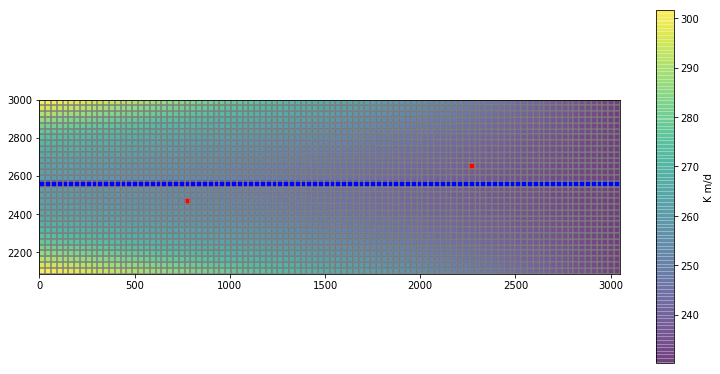

In [16]:
# plot some model attributes
fig = plt.figure(figsize=(13,13))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.ModelMap(model=mf)
mm.plot_grid()
ax = mm.ax
mf.dis.top.plot(axes=[ax],colorbar="K m/d",alpha=0.5)
mf.wel.stress_period_data.plot(axes=[ax], kper=1)
mf.sfr.stress_period_data.plot(axes=[ax])

D:\EDM_LT\GitHub\usgsgw3099_classrepo.git\exercises\MT3DUSGS


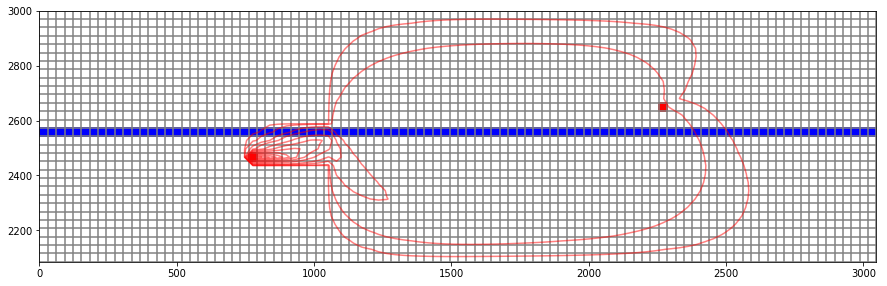

In [17]:
# Load binary concentration file
ucn = bf.UcnFile(os.path.join(modelpth,'{0}.ucn'.format('mt3d001')))
totim = ucn.get_times()
conc = []
for i in totim:
    conc.append(ucn.get_data(totim=i))

conc = np.array(conc)
conc.shape

# plot the concentrations
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
axes.set_aspect('equal')
cmin = conc.min()
cmax = conc.max()

# set the contour list
levels = np.linspace(cmin, cmax, 11)
levels = levels.tolist()
levels.pop(0)
levels = [0.1,1,5] + levels

ax.set_title('Layer {}'.format(1))
mm = flopy.plot.ModelMap(model=mf, ax=axes)
mm.plot_grid()
ax = mm.ax
mm.contour_array(conc[210,0,:,:], masked_values=[-1.], alpha=0.5, levels=levels, colors='red')

#quadmesh = mm.plot_array(conc[200,0,15:25,20:30], masked_values=[-1.], alpha=0.1, 
#                         vmin=cmin, vmax=cmax, cmap='jet')
mf.wel.stress_period_data.plot(axes=[ax], kper=1)
mf.sfr.stress_period_data.plot(axes=[ax])

print(os.getcwd())
fname = os.path.join('Cara_model', 'Spill.sftcobs.out')
# dt = pd.read_table(fname, header=[1])